# Processing data using Spark Dataframe with Pyspark

View spark version. If you get an error, you need to troubleshoot the reason further.

In [1]:
spark.version

'2.1.1'

### Exercise 1: use movielens dataset for the following exercise

1. Load movies.csv as movies dataframe. Cache the dataframe
2. Load ratings.csv as ratings dataframe. Cache the dataframe
3. Find the number of records in movies dataframe
4. Find the number of records in ratings dataframe
5. Validate the userId and movieId combination is unique
6. Find average rating and count of rating per movieId using ratings dataframe
7. Find top 10 movies based on the highest average ratings. Consider only those movies that have at least 100 ratings. Show movieId, title, average rating and rating count columns.
8. Show temporary views for current Spark session
9. Register movies dataframe and ratings dayaframe as movies and ratings temporary view respectively. Verify that you can see the new temporary views you just created.
10. Using SQL statement, solve the problem statement for step #7. Match the results from step #7.

Load Spark SQL functions, for example: count, avg, explode etc.

In [2]:
from pyspark.sql.functions import *

Location of movies dataset. You can download the dataset from here. Here we are using latest-small dataset.

In [3]:
home_dir = "movielens"

Create a dataframe on movies.csv file

In [4]:
movies = (spark.read.format("csv")
.options(header = True, inferSchema = True)
.load(home_dir + "/movies")
.cache()) # Keep the dataframe in memory for faster processing 

Show schema of movies dataframe

In [5]:
movies.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [6]:
movies.dtypes

[('movieId', 'int'), ('title', 'string'), ('genres', 'string')]

Display a few sample view from movies Dataframe

In [7]:
movies.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



Find the number of records in movies dataframe

In [8]:
movies.count()

10329

Create ratings Dataframe using ratings.csv file

In [9]:
ratings = (spark.read.format("csv")
.options(header = True, inferSchema = True)
.load(home_dir + "/ratings")
.persist())

Print schema of ratings Dataframe

In [10]:
ratings.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



Show a few sample values from ratings dataframe

In [11]:
ratings.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|     16|   4.0|1217897793|
|     1|     24|   1.5|1217895807|
|     1|     32|   4.0|1217896246|
|     1|     47|   4.0|1217896556|
|     1|     50|   4.0|1217896523|
+------+-------+------+----------+
only showing top 5 rows



Find the number of records in ratings

In [12]:
ratings.count()

105339

Validate the movieId and ratingId combination is unique identifier in ratings table

In [13]:
ratings.groupBy("movieId", "userId").count().filter("count != 1").show()

+-------+------+-----+
|movieId|userId|count|
+-------+------+-----+
+-------+------+-----+



As it shows that there is no userId and movieId combination that occurs more than once. 

Find average rating of each movie for which there are at least 100 ratings. Order the result by average rating in decreasing order.

In [14]:
ratings_agg = (ratings
.groupBy(col("movieId"))
.agg(
    count(col("movieId")).alias("count"),
    avg(col("rating")).alias("avg_rating")
))

ratings_agg.show()

+-------+-----+------------------+
|movieId|count|        avg_rating|
+-------+-----+------------------+
|   1580|  172| 3.627906976744186|
|    471|   48|3.6666666666666665|
|   7253|    2|               4.0|
|   3997|   11|               2.5|
|  32460|    1|               4.5|
|  44022|   16|            3.3125|
|  54190|    7| 3.357142857142857|
|    833|   10|              2.95|
|   1591|   33| 2.257575757575758|
|   6357|    5|               3.6|
|   2366|   31| 3.532258064516129|
|   1088|   56| 3.419642857142857|
|   1238|   12|              3.75|
|   4519|   11|3.0454545454545454|
|   1645|   60| 3.566666666666667|
|   8638|   18|3.9722222222222223|
|   3175|   73| 3.712328767123288|
|   2122|   14|2.2142857142857144|
|  26755|    1|               0.5|
|   5803|    7|2.5714285714285716|
+-------+-----+------------------+
only showing top 20 rows



In [15]:
(ratings_agg
.alias("t1")
.join(movies.alias("t2"), col("t1.movieId") == col("t2.movieId"))
.filter("count > 100")
.orderBy(desc("avg_rating"))
.select("t1.movieId", "title", "avg_rating", "count")
.limit(10)
.show())

+-------+--------------------+------------------+-----+
|movieId|               title|        avg_rating|count|
+-------+--------------------+------------------+-----+
|    318|Shawshank Redempt...| 4.454545454545454|  308|
|    858|Godfather, The (1...| 4.392857142857143|  210|
|     50|Usual Suspects, T...| 4.328947368421052|  228|
|   1136|Monty Python and ...|4.3019480519480515|  154|
|    527|Schindler's List ...| 4.296370967741935|  248|
|   1193|One Flew Over the...|4.2727272727272725|  143|
|    608|        Fargo (1996)|4.2711442786069655|  201|
|   2571|  Matrix, The (1999)| 4.264367816091954|  261|
|   1221|Godfather: Part I...| 4.260714285714286|  140|
|   1213|   Goodfellas (1990)|4.2592592592592595|  135|
+-------+--------------------+------------------+-----+



Show temporary views for current Spark session

In [16]:
sql("show tables").show()

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
| default|  weblogs|      false|
+--------+---------+-----------+



In [17]:
movies.createOrReplaceTempView("movies")
ratings.createOrReplaceTempView("ratings")
sql("show tables").show()

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
| default|  weblogs|      false|
|        |   movies|       true|
|        |  ratings|       true|
+--------+---------+-----------+



Using SQL statement, find top 10 movies based on the highest average ratings. Consider only those movies that have at least 100 ratings. Show movieId, title, average rating and rating count columns.

In [18]:
sql("""
select t1.movieId, t1.title, avg(t2.rating) avg_rating, count(1) rating_count 
from movies t1 join ratings t2 on t1.movieId = t2.movieId group by t1.movieId, t1.title
having rating_count >= 100
order by avg_rating desc limit 10
""").show()

+-------+--------------------+------------------+------------+
|movieId|               title|        avg_rating|rating_count|
+-------+--------------------+------------------+------------+
|    318|Shawshank Redempt...| 4.454545454545454|         308|
|    858|Godfather, The (1...| 4.392857142857143|         210|
|     50|Usual Suspects, T...| 4.328947368421052|         228|
|   1136|Monty Python and ...|4.3019480519480515|         154|
|    527|Schindler's List ...| 4.296370967741935|         248|
|   1193|One Flew Over the...|4.2727272727272725|         143|
|    608|        Fargo (1996)|4.2711442786069655|         201|
|   2571|  Matrix, The (1999)| 4.264367816091954|         261|
|   1221|Godfather: Part I...| 4.260714285714286|         140|
|   1213|   Goodfellas (1990)|4.2592592592592595|         135|
+-------+--------------------+------------------+------------+



Find average rating of each genre

In [19]:
genre_avg_rating = (ratings.alias("t1")
.join(movies.alias("t2"), col("t1.movieId") == col("t2.movieId"))
.select(col("rating"), explode(split("genres", r"\|")).alias("genre"))
.groupBy(col("genre"))
.agg(count(col("genre")).alias("count"), avg("rating").alias("avg_rating"))
.orderBy(desc("avg_rating")))

genre_avg_rating.show()

+------------------+-----+------------------+
|             genre|count|        avg_rating|
+------------------+-----+------------------+
|         Film-Noir| 1210|3.9136363636363636|
|               War| 5828|3.7832017844886754|
|           Mystery| 8320| 3.652043269230769|
|             Drama|46960|3.6502661839863713|
|       Documentary| 1206|3.6430348258706466|
|             Crime|18291|3.6423924334372098|
|              IMAX| 3032| 3.641820580474934|
|         Animation| 5966|3.6353503184713376|
|           Musical| 4287|  3.57196174480989|
|           Western| 2314| 3.565687121866897|
|           Romance|19094| 3.544254739708809|
|         Adventure|23076| 3.518027387762177|
|           Fantasy|10889|3.5004591789879695|
|          Thriller|29288|3.4955613220431574|
|            Sci-Fi|16795|3.4544805001488537|
|            Action|31205|3.4514500881269026|
|          Children| 8098|3.4394294887626575|
|            Comedy|38055|3.4209959269478385|
|            Horror| 7983| 3.28109

### Using matplotlib show barplot of average rating for each genre

Loading matplotlib library

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Convert spark dataframe to Pandas Dataframe. 

In [21]:
df = genre_avg_rating.toPandas()
df.head()

,genre,count,avg_rating
0,Film-Noir,1210,3.913636
1,War,5828,3.783202
2,Mystery,8320,3.652043
3,Drama,46960,3.650266
4,Documentary,1206,3.643035


Plot average rating for each genre

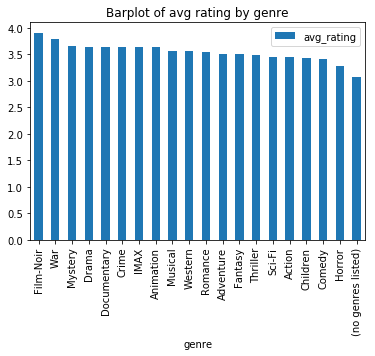

In [22]:
df.plot("genre", "avg_rating", "bar", title = "Barplot of avg rating by genre")

### Exercise 2: Use stocks.csv for the following execise
1. Load stocks.csv as stocks dataframe with scheme inferencing enabled. Cache the dataframe.
2. What are the data type for each columns?
3. Cast the date field of stocks dataframe as date type
4. What is the largest value in date column. You should get 2016-08-15. 
5. Register the stocks dataframe as stocks temporary view.
5. Create a new dataframe, stocks_last10 with last 10 records for each stock. Select date, symbol and adjclose columns. You can use SQL statement and SQL window operation. [Hint: if you are not familiar with window operation in SQL, please refer this - https://databricks.com/blog/2015/07/15/introducing-window-functions-in-spark-sql.html]
6. Create a new dataframe stocks_pivot, by pivoting the stocks_last10 dataframe
7. Find difference between adjclose for each pair of consecutive days  

In [23]:
stocks = (spark
          .read
          .format("csv")
          .options(inferSchema = True, header = True)
          .load("stocks")
          .cache())
stocks.show()

+--------------------+---------+---------+---------+---------+---------+---------+------+
|                date|     open|     high|      low|    close|   volume| adjclose|symbol|
+--------------------+---------+---------+---------+---------+---------+---------+------+
|2000-07-17 00:00:...|  95.4375|     97.5|    92.75|   96.625|3508100.0|74.269199|  XLNX|
|2000-07-17 00:00:...|   22.625|    22.75|  22.4375|  22.5625| 201600.0| 13.48614|    ES|
|2000-07-17 00:00:...| 6.750002| 6.937503|    6.375|      6.5|1235700.0| 5.241649|   CHK|
|2000-07-17 00:00:...|19.812501|  20.1875|19.500001|  20.1875|1434100.0| 3.806147|    NI|
|2000-07-17 00:00:...|     30.5|  30.6875|     30.0| 30.03125| 254600.0| 19.81183|   SNA|
|2000-07-17 00:00:...|44.749996|45.062498|44.500004|45.000009| 535200.0|17.400773|  FOXA|
|2000-07-17 00:00:...|   19.625|   19.625|    19.25|   19.375| 309500.0|13.768835|     R|
|2000-07-17 00:00:...|  16.6562|  16.6875|   16.125|    16.25|5507200.0| 1.755466|  ROST|
|2000-07-1

In [24]:
stocks.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: double (nullable = true)
 |-- adjclose: double (nullable = true)
 |-- symbol: string (nullable = true)



In [25]:
stocks.withColumn("date", col("date").cast("date")).printSchema()

root
 |-- date: date (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: double (nullable = true)
 |-- adjclose: double (nullable = true)
 |-- symbol: string (nullable = true)



In [26]:
stocks = stocks.withColumn("date", col("date").cast("date"))
stocks.show()

+----------+---------+---------+---------+---------+---------+---------+------+
|      date|     open|     high|      low|    close|   volume| adjclose|symbol|
+----------+---------+---------+---------+---------+---------+---------+------+
|2000-07-17|  95.4375|     97.5|    92.75|   96.625|3508100.0|74.269199|  XLNX|
|2000-07-17|   22.625|    22.75|  22.4375|  22.5625| 201600.0| 13.48614|    ES|
|2000-07-17| 6.750002| 6.937503|    6.375|      6.5|1235700.0| 5.241649|   CHK|
|2000-07-17|19.812501|  20.1875|19.500001|  20.1875|1434100.0| 3.806147|    NI|
|2000-07-17|     30.5|  30.6875|     30.0| 30.03125| 254600.0| 19.81183|   SNA|
|2000-07-17|44.749996|45.062498|44.500004|45.000009| 535200.0|17.400773|  FOXA|
|2000-07-17|   19.625|   19.625|    19.25|   19.375| 309500.0|13.768835|     R|
|2000-07-17|  16.6562|  16.6875|   16.125|    16.25|5507200.0| 1.755466|  ROST|
|2000-07-17|    56.25|    57.25|  56.0625|   56.125|7941200.0| 18.31076|    PG|
|2000-07-17|54.000326|54.000326|52.50031

In [27]:
stocks.orderBy(col("date").desc()).show(1)

+----------+-----+-----+----+---------+---------+---------+------+
|      date| open| high| low|    close|   volume| adjclose|symbol|
+----------+-----+-----+----+---------+---------+---------+------+
|2016-08-15|52.02|52.43|52.0|52.040001|1702400.0|52.040001|  XLNX|
+----------+-----+-----+----+---------+---------+---------+------+
only showing top 1 row



In [28]:
stocks.createOrReplaceTempView("stocks")

In [29]:
stocks_last10 = sql("""
select 
        cast(t1.date as string),
        t1.symbol,
        t1.adjclose,
        t1.row_num
    from (select 
            *, 
            row_number() over (partition by symbol order by date desc) row_num 
        from stocks) t1 where t1.row_num <= 11
""")

stocks_last10.show()

+----------+------+----------+-------+
|      date|symbol|  adjclose|row_num|
+----------+------+----------+-------+
|2016-08-15|  ALXN|136.070007|      1|
|2016-08-12|  ALXN|133.440002|      2|
|2016-08-11|  ALXN|133.669998|      3|
|2016-08-10|  ALXN|132.669998|      4|
|2016-08-09|  ALXN|     135.0|      5|
|2016-08-08|  ALXN|136.080002|      6|
|2016-08-05|  ALXN|137.110001|      7|
|2016-08-04|  ALXN|135.429993|      8|
|2016-08-03|  ALXN|137.660004|      9|
|2016-08-02|  ALXN|133.610001|     10|
|2016-08-01|  ALXN|     133.5|     11|
|2016-08-15|   GIS| 71.040001|      1|
|2016-08-12|   GIS| 71.169998|      2|
|2016-08-11|   GIS|     71.07|      3|
|2016-08-10|   GIS| 71.059998|      4|
|2016-08-09|   GIS|     70.93|      5|
|2016-08-08|   GIS| 70.629997|      6|
|2016-08-05|   GIS| 70.550003|      7|
|2016-08-04|   GIS| 70.489998|      8|
|2016-08-03|   GIS| 69.779999|      9|
+----------+------+----------+-------+
only showing top 20 rows



In [30]:
stocks_pivot = stocks_last10.groupby("symbol").pivot("date").agg(max(col("adjclose")))
stocks_pivot.limit(10).toPandas()

,symbol,2016-08-01,2016-08-02,2016-08-03,2016-08-04,2016-08-05,2016-08-08,2016-08-09,2016-08-10,2016-08-11,2016-08-12,2016-08-15
0,ALXN,133.500000,133.610001,137.660004,135.429993,137.110001,136.080002,135.000000,132.669998,133.669998,133.440002,136.070007
1,GIS,71.629997,70.970001,69.779999,70.489998,70.550003,70.629997,70.930000,71.059998,71.070000,71.169998,71.040001
2,K,82.370003,81.870003,81.080002,82.419998,82.709999,82.919998,82.980003,82.959999,83.459999,83.529999,83.389999
3,LEN,46.750000,45.529999,45.740002,45.810001,46.799999,46.619999,46.830002,46.799999,47.160000,46.750000,47.299999
4,SPGI,121.220001,120.110001,120.510002,119.620003,120.900002,120.160004,120.580002,119.830002,120.410004,119.910004,120.260002
5,AIV,46.060001,45.169998,45.049999,44.880001,45.360001,45.880001,45.980000,45.400002,44.869999,45.049999,45.540001
6,AVY,78.150002,77.849998,77.239998,77.389999,78.459999,78.720001,78.730003,78.690002,78.300003,78.190002,78.169998
7,MMM,178.289993,178.360001,178.380005,177.809998,178.570007,178.580002,178.389999,178.820007,181.000000,180.270004,180.559998
8,PKI,56.689999,55.910000,55.750000,55.720001,54.849998,54.590000,54.720001,54.540001,54.720001,54.410000,54.610001
9,PPG,104.269079,103.292837,103.930385,103.701263,104.030001,104.480003,104.370003,104.690002,104.739998,103.989998,104.459999


In [31]:
columns = ["v" + str(i) for i in range(len(stocks_pivot.columns) - 1)]
columns.insert(0, "symbol")
columns

['symbol', 'v0', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10']

In [32]:
stocks_pivot = stocks_pivot.toDF(*columns)
stocks_pivot.limit(10).toPandas()

,symbol,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10
0,ALXN,133.500000,133.610001,137.660004,135.429993,137.110001,136.080002,135.000000,132.669998,133.669998,133.440002,136.070007
1,GIS,71.629997,70.970001,69.779999,70.489998,70.550003,70.629997,70.930000,71.059998,71.070000,71.169998,71.040001
2,K,82.370003,81.870003,81.080002,82.419998,82.709999,82.919998,82.980003,82.959999,83.459999,83.529999,83.389999
3,LEN,46.750000,45.529999,45.740002,45.810001,46.799999,46.619999,46.830002,46.799999,47.160000,46.750000,47.299999
4,SPGI,121.220001,120.110001,120.510002,119.620003,120.900002,120.160004,120.580002,119.830002,120.410004,119.910004,120.260002
5,AIV,46.060001,45.169998,45.049999,44.880001,45.360001,45.880001,45.980000,45.400002,44.869999,45.049999,45.540001
6,AVY,78.150002,77.849998,77.239998,77.389999,78.459999,78.720001,78.730003,78.690002,78.300003,78.190002,78.169998
7,MMM,178.289993,178.360001,178.380005,177.809998,178.570007,178.580002,178.389999,178.820007,181.000000,180.270004,180.559998
8,PKI,56.689999,55.910000,55.750000,55.720001,54.849998,54.590000,54.720001,54.540001,54.720001,54.410000,54.610001
9,PPG,104.269079,103.292837,103.930385,103.701263,104.030001,104.480003,104.370003,104.690002,104.739998,103.989998,104.459999


In [33]:
stocks_diff = stocks_pivot
for i in range(1, len(stocks_diff.columns) - 1):
    stocks_diff = stocks_diff.withColumn(columns[i], col(columns[i]) - col(columns[i+1]))

stocks_diff = stocks_diff.drop(stocks_diff.columns[-1])
stocks_diff.limit(10).toPandas()

,symbol,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9
0,ALXN,-0.110001,-4.050003,2.230011,-1.680008,1.029999,1.080002,2.330002,-1.000000,0.229996,-2.630005
1,GIS,0.659996,1.190002,-0.709999,-0.060005,-0.079994,-0.300003,-0.129998,-0.010002,-0.099998,0.129997
2,K,0.500000,0.790001,-1.339996,-0.290001,-0.209999,-0.060005,0.020004,-0.500000,-0.070000,0.140000
3,LEN,1.220001,-0.210003,-0.069999,-0.989998,0.180000,-0.210003,0.030003,-0.360001,0.410000,-0.549999
4,SPGI,1.110000,-0.400001,0.889999,-1.279999,0.739998,-0.419998,0.750000,-0.580002,0.500000,-0.349998
5,AIV,0.890003,0.119999,0.169998,-0.480000,-0.520000,-0.099999,0.579998,0.530003,-0.180000,-0.490002
6,AVY,0.300004,0.610000,-0.150001,-1.070000,-0.260002,-0.010002,0.040001,0.389999,0.110001,0.020004
7,MMM,-0.070008,-0.020004,0.570007,-0.760009,-0.009995,0.190003,-0.430008,-2.179993,0.729996,-0.289994
8,PKI,0.779999,0.160000,0.029999,0.870003,0.259998,-0.130001,0.180000,-0.180000,0.310001,-0.200001
9,PPG,0.976242,-0.637548,0.229122,-0.328738,-0.450002,0.110000,-0.319999,-0.049996,0.750000,-0.470001


### Exercise 3: Read data from mysql 

1. Create a dataframe - orders in Spark based on orders table in retail_db in mysql
2. Save the orders as parquet file in HDFS
3. Write a query joining customers table in mysql and orders parquet file in HDFS to find customers with most number of completed orders.
4. Save the orders dataframe as hive table. Verify that orders table is accessible in hive as well.
5. Delete the orders table from hive.

Create a dataframe - orders in Spark based on orders table in retail_db in mysql

In [34]:
orders = (spark
             .read
             .format("jdbc")
             .option("url", "jdbc:mysql://localhost/retail_db")
             .option("driver", "com.mysql.jdbc.Driver")
             .option("dbtable", "orders")
             .option("user", "root")
             .option("password", "cloudera")
             .load())
orders.show()         

+--------+--------------------+-----------------+---------------+
|order_id|          order_date|order_customer_id|   order_status|
+--------+--------------------+-----------------+---------------+
|       1|2013-07-25 00:00:...|            11599|         CLOSED|
|       2|2013-07-25 00:00:...|              256|PENDING_PAYMENT|
|       3|2013-07-25 00:00:...|            12111|       COMPLETE|
|       4|2013-07-25 00:00:...|             8827|         CLOSED|
|       5|2013-07-25 00:00:...|            11318|       COMPLETE|
|       6|2013-07-25 00:00:...|             7130|       COMPLETE|
|       7|2013-07-25 00:00:...|             4530|       COMPLETE|
|       8|2013-07-25 00:00:...|             2911|     PROCESSING|
|       9|2013-07-25 00:00:...|             5657|PENDING_PAYMENT|
|      10|2013-07-25 00:00:...|             5648|PENDING_PAYMENT|
|      11|2013-07-25 00:00:...|              918| PAYMENT_REVIEW|
|      12|2013-07-25 00:00:...|             1837|         CLOSED|
|      13|

Save the orders as parquet file in HDFS

In [35]:
orders.write.format("parquet").mode("overwrite").save("orders")

Create a dataframe customers, based on the customers table in retail_db in mysql database.

In [36]:
customers = (spark
             .read
             .format("jdbc")
             .option("url", "jdbc:mysql://localhost/retail_db")
             .option("driver", "com.mysql.jdbc.Driver")
             .option("dbtable", "customers")
             .option("user", "root")
             .option("password", "cloudera")
             .load())
customers.show(5)    

+-----------+--------------+--------------+--------------+-----------------+--------------------+-------------+--------------+----------------+
|customer_id|customer_fname|customer_lname|customer_email|customer_password|     customer_street|customer_city|customer_state|customer_zipcode|
+-----------+--------------+--------------+--------------+-----------------+--------------------+-------------+--------------+----------------+
|          1|       Richard|     Hernandez|     XXXXXXXXX|        XXXXXXXXX|  6303 Heather Plaza|  Brownsville|            TX|           78521|
|          2|          Mary|       Barrett|     XXXXXXXXX|        XXXXXXXXX|9526 Noble Embers...|    Littleton|            CO|           80126|
|          3|           Ann|         Smith|     XXXXXXXXX|        XXXXXXXXX|3422 Blue Pioneer...|       Caguas|            PR|           00725|
|          4|          Mary|         Jones|     XXXXXXXXX|        XXXXXXXXX|  8324 Little Common|   San Marcos|            CA|          

Create an orders based on the orders parquet file. 

In [37]:
orders = spark.read.load("orders")
orders.show(6)

+--------+--------------------+-----------------+---------------+
|order_id|          order_date|order_customer_id|   order_status|
+--------+--------------------+-----------------+---------------+
|       1|2013-07-25 00:00:...|            11599|         CLOSED|
|       2|2013-07-25 00:00:...|              256|PENDING_PAYMENT|
|       3|2013-07-25 00:00:...|            12111|       COMPLETE|
|       4|2013-07-25 00:00:...|             8827|         CLOSED|
|       5|2013-07-25 00:00:...|            11318|       COMPLETE|
|       6|2013-07-25 00:00:...|             7130|       COMPLETE|
+--------+--------------------+-----------------+---------------+
only showing top 6 rows



Write a query joining customers table in mysql and orders parquet file in HDFS to find most number of complet orders.

In [38]:
(orders.alias("t1")
.join(customers.alias("t2"), col("t1.order_customer_id") == col("t2.customer_id"))
.filter("t1.order_status == 'COMPLETE'")
.groupby("order_customer_id", "customer_fname", "customer_lname")
.count()
.orderBy(col("count").desc())
.show(10))

+-----------------+--------------+--------------+-----+
|order_customer_id|customer_fname|customer_lname|count|
+-----------------+--------------+--------------+-----+
|             9337|          Mary|         Smith|   10|
|             7802|          Mary|       Acevedo|    9|
|             3710|        Ashley|         Smith|    9|
|              749|         Jesse|      Matthews|    9|
|             5186|         Jason|      Robinson|    8|
|              221|          Mary|           Cox|    8|
|             2469|         Shawn|         Smith|    8|
|            11061|        Joseph|       Webster|    8|
|             5283|         Jacob|      Guerrero|    8|
|             7910|          Mary|       Camacho|    8|
+-----------------+--------------+--------------+-----+
only showing top 10 rows



In [39]:
orders.write.mode("overwrite").saveAsTable("orders")

Verify the table in Hive. See whether orders table shows up as a permanent table. You can use use describe formatted <table> command to see what type of hive file it is.

In [40]:
sql("show tables").show()

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
| default|   orders|      false|
| default|  weblogs|      false|
|        |   movies|       true|
|        |  ratings|       true|
|        |   stocks|       true|
+--------+---------+-----------+



In [41]:
spark.table("orders").show(10)

+--------+--------------------+-----------------+---------------+
|order_id|          order_date|order_customer_id|   order_status|
+--------+--------------------+-----------------+---------------+
|       1|2013-07-25 00:00:...|            11599|         CLOSED|
|       2|2013-07-25 00:00:...|              256|PENDING_PAYMENT|
|       3|2013-07-25 00:00:...|            12111|       COMPLETE|
|       4|2013-07-25 00:00:...|             8827|         CLOSED|
|       5|2013-07-25 00:00:...|            11318|       COMPLETE|
|       6|2013-07-25 00:00:...|             7130|       COMPLETE|
|       7|2013-07-25 00:00:...|             4530|       COMPLETE|
|       8|2013-07-25 00:00:...|             2911|     PROCESSING|
|       9|2013-07-25 00:00:...|             5657|PENDING_PAYMENT|
|      10|2013-07-25 00:00:...|             5648|PENDING_PAYMENT|
+--------+--------------------+-----------------+---------------+
only showing top 10 rows



In [42]:
sql("describe formatted orders").toPandas()

,col_name,data_type,comment
0,order_id,int,None
1,order_date,timestamp,None
2,order_customer_id,int,None
3,order_status,string,None
4,,,
5,# Detailed Table Information,,
6,Database:,default,
7,Owner:,cloudera,
8,Create Time:,Tue Oct 03 01:30:25 PDT 2017,
9,Last Access Time:,Wed Dec 31 16:00:00 PST 1969,


Drop the table from hive

In [43]:
sql("drop table orders").show()

++
||
++
++



### Exercise 4: Use SFPD Dataset for the following tasks

File: Map__Crime_Incidents_-_from_1_Jan_2003.csv

Tasks:
1. Create an dataframe with crime incident data.
3. Show the first 10 values of an dataframe
4. Check number of partitions of the dataframe
5. Find the number of incident records in the dataframe
6. Find the categories of incidents
7. Find total number of categories
8. What are the total number of incidents in each category
9. Find out on which day each of incidents have occurred most. 
10. [Optional] Plot the frequency for each category of events
11. Convert the data type of Date field to date type

In [44]:
sfpd = (spark
        .read
        .format("csv")
        .option("header", True)
        .option("inferSchema", True)
        .load("sfpd")
       )
sfpd.printSchema()

root
 |-- IncidntNum: integer (nullable = true)
 |-- Category: string (nullable = true)
 |-- Descript: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- PdDistrict: string (nullable = true)
 |-- Resolution: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- X: double (nullable = true)
 |-- Y: double (nullable = true)
 |-- Location: string (nullable = true)



In [45]:
sfpd.limit(5).toPandas()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location
0,50436712,ASSAULT,BATTERY,Wednesday,04/20/2005 12:00:00 AM,04:00,MISSION,NONE,18TH ST / CASTRO ST,-122.435003,37.760888,"(37.7608878061245, -122.435002864271)"
1,80049078,LARCENY/THEFT,GRAND THEFT FROM A BUILDING,Sunday,01/13/2008 12:00:00 AM,18:00,PARK,NONE,1100 Block of CLAYTON ST,-122.446838,37.762255,"(37.7622550270122, -122.446837820235)"
2,130366639,ASSAULT,AGGRAVATED ASSAULT WITH A KNIFE,Sunday,05/05/2013 12:00:00 AM,04:10,INGLESIDE,"ARREST, BOOKED",0 Block of SGTJOHNVYOUNG LN,-122.444707,37.724931,"(37.7249307267936, -122.444707063455)"
3,30810835,DRIVING UNDER THE INFLUENCE,DRIVING WHILE UNDER THE INFLUENCE OF ALCOHOL,Tuesday,07/08/2003 12:00:00 AM,01:00,SOUTHERN,"ARREST, BOOKED",MASON ST / TURK ST,-122.408954,37.783288,"(37.7832878735491, -122.408953598286)"
4,130839567,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Friday,10/04/2013 12:00:00 AM,20:53,TENDERLOIN,"ARREST, BOOKED",TURK ST / LEAVENWORTH ST,-122.414056,37.782793,"(37.7827931071006, -122.414056291891)"


In [46]:
sfpd.rdd.getNumPartitions()

3

In [47]:
type(sfpd.first())

pyspark.sql.types.Row

In [48]:
categories = sfpd.select("Category").distinct().rdd.map(lambda r: r.Category)
print(categories.collect())

['FRAUD', 'SUICIDE', 'LIQUOR LAWS', 'SECONDARY CODES', 'FAMILY OFFENSES', 'MISSING PERSON', 'OTHER OFFENSES', 'DRIVING UNDER THE INFLUENCE', 'WARRANTS', 'ARSON', 'FORGERY/COUNTERFEITING', 'GAMBLING', 'BRIBERY', 'ASSAULT', 'DRUNKENNESS', 'EXTORTION', 'TREA', 'WEAPON LAWS', 'LOITERING', 'SUSPICIOUS OCC', 'ROBBERY', 'SEX OFFENSES, FORCIBLE', 'PROSTITUTION', 'EMBEZZLEMENT', 'BAD CHECKS', 'DISORDERLY CONDUCT', 'RUNAWAY', 'RECOVERED VEHICLE', 'VANDALISM', 'DRUG/NARCOTIC', 'PORNOGRAPHY/OBSCENE MAT', 'TRESPASS', 'NON-CRIMINAL', 'VEHICLE THEFT', 'STOLEN PROPERTY', 'LARCENY/THEFT', 'KIDNAPPING', 'BURGLARY', 'SEX OFFENSES, NON FORCIBLE']


In [49]:
categories_count = categories.count()
categories_count

39

In [50]:
category_counts = sfpd.groupBy("Category").count().orderBy(col("count").desc())
category_counts.show(categories_count, False)

+---------------------------+------+
|Category                   |count |
+---------------------------+------+
|LARCENY/THEFT              |385774|
|OTHER OFFENSES             |269250|
|NON-CRIMINAL               |200942|
|ASSAULT                    |165324|
|VEHICLE THEFT              |114258|
|DRUG/NARCOTIC              |111436|
|VANDALISM                  |96350 |
|WARRANTS                   |89782 |
|BURGLARY                   |78968 |
|SUSPICIOUS OCC             |67788 |
|MISSING PERSON             |55584 |
|ROBBERY                    |48713 |
|FRAUD                      |36004 |
|FORGERY/COUNTERFEITING     |21804 |
|SECONDARY CODES            |21636 |
|WEAPON LAWS                |18533 |
|TRESPASS                   |15798 |
|PROSTITUTION               |15657 |
|STOLEN PROPERTY            |10096 |
|SEX OFFENSES, FORCIBLE     |9541  |
|DRUNKENNESS                |9032  |
|DISORDERLY CONDUCT         |8992  |
|RECOVERED VEHICLE          |6346  |
|DRIVING UNDER THE INFLUENCE|4953  |
|

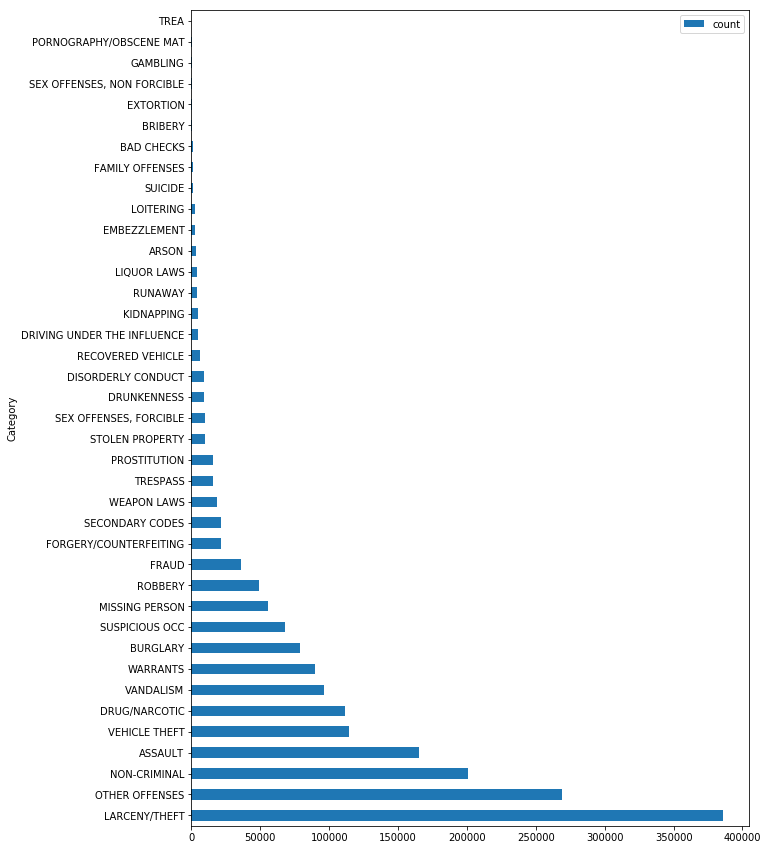

In [51]:
category_counts.toPandas().set_index("Category").plot.barh(figsize = (10, 15))

In [52]:
sfpd.select("date").show(10, False)

+----------------------+
|date                  |
+----------------------+
|04/20/2005 12:00:00 AM|
|01/13/2008 12:00:00 AM|
|05/05/2013 12:00:00 AM|
|07/08/2003 12:00:00 AM|
|10/04/2013 12:00:00 AM|
|08/14/2007 12:00:00 AM|
|03/04/2008 12:00:00 AM|
|07/05/2006 12:00:00 AM|
|12/10/2003 12:00:00 AM|
|01/17/2011 12:00:00 AM|
+----------------------+
only showing top 10 rows



In [53]:
from datetime import datetime
s = "04/20/2005 12:00:00 AM"
d = datetime.strptime(s[:10], "%m/%d/%Y").date()
d

datetime.date(2005, 4, 20)

In [54]:
from datetime import datetime
def parse_date(s):
    return datetime.strptime(s[:10], "%m/%d/%Y").date()

parse_date("04/20/2005 12:00:00 AM")

datetime.date(2005, 4, 20)

In [55]:
from pyspark.sql.types import DateType
spark.udf.register("parse_date", parse_date, DateType())

In [56]:
sfpd.select(expr("date"), expr("parse_date(`date`)")).show(10, False)

+----------------------+----------------+
|date                  |parse_date(date)|
+----------------------+----------------+
|04/20/2005 12:00:00 AM|2005-04-20      |
|01/13/2008 12:00:00 AM|2008-01-13      |
|05/05/2013 12:00:00 AM|2013-05-05      |
|07/08/2003 12:00:00 AM|2003-07-08      |
|10/04/2013 12:00:00 AM|2013-10-04      |
|08/14/2007 12:00:00 AM|2007-08-14      |
|03/04/2008 12:00:00 AM|2008-03-04      |
|07/05/2006 12:00:00 AM|2006-07-05      |
|12/10/2003 12:00:00 AM|2003-12-10      |
|01/17/2011 12:00:00 AM|2011-01-17      |
+----------------------+----------------+
only showing top 10 rows



In [57]:
sfpd_clean = sfpd.withColumn("date", expr("parse_date(date)"))
sfpd_clean.limit(10).toPandas()

,IncidntNum,Category,Descript,DayOfWeek,date,Time,PdDistrict,Resolution,Address,X,Y,Location
0,50436712,ASSAULT,BATTERY,Wednesday,2005-04-20,04:00,MISSION,NONE,18TH ST / CASTRO ST,-122.435003,37.760888,"(37.7608878061245, -122.435002864271)"
1,80049078,LARCENY/THEFT,GRAND THEFT FROM A BUILDING,Sunday,2008-01-13,18:00,PARK,NONE,1100 Block of CLAYTON ST,-122.446838,37.762255,"(37.7622550270122, -122.446837820235)"
2,130366639,ASSAULT,AGGRAVATED ASSAULT WITH A KNIFE,Sunday,2013-05-05,04:10,INGLESIDE,"ARREST, BOOKED",0 Block of SGTJOHNVYOUNG LN,-122.444707,37.724931,"(37.7249307267936, -122.444707063455)"
3,30810835,DRIVING UNDER THE INFLUENCE,DRIVING WHILE UNDER THE INFLUENCE OF ALCOHOL,Tuesday,2003-07-08,01:00,SOUTHERN,"ARREST, BOOKED",MASON ST / TURK ST,-122.408954,37.783288,"(37.7832878735491, -122.408953598286)"
4,130839567,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Friday,2013-10-04,20:53,TENDERLOIN,"ARREST, BOOKED",TURK ST / LEAVENWORTH ST,-122.414056,37.782793,"(37.7827931071006, -122.414056291891)"
5,70838580,BURGLARY,"BURGLARY OF APARTMENT HOUSE, UNLAWFUL ENTRY",Tuesday,2007-08-14,07:00,NORTHERN,NONE,3100 Block of FRANKLIN ST,-122.426731,37.803467,"(37.8034674969672, -122.426730544229)"
6,80233102,DRUG/NARCOTIC,POSSESSION OF MARIJUANA,Tuesday,2008-03-04,14:23,INGLESIDE,"ARREST, CITED",MISSION ST / PERSIA AV,-122.435977,37.723129,"(37.7231288306727, -122.43597721703)"
7,60711805,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Wednesday,2006-07-05,15:50,INGLESIDE,"ARREST, CITED",2300 Block of SAN JOSE AV,-122.447241,37.720158,"(37.7201577971255, -122.447241159611)"
8,40062593,LARCENY/THEFT,GRAND THEFT FROM A BUILDING,Wednesday,2003-12-10,09:30,INGLESIDE,NONE,0 Block of MOFFITT ST,-122.432788,37.737157,"(37.7371566745272, -122.432787775164)"
9,110051822,NON-CRIMINAL,"STAY AWAY OR COURT ORDER, NON-DV RELATED",Monday,2011-01-17,15:35,INGLESIDE,NONE,600 Block of CAMPBELL AV,-122.408761,37.715900,"(37.7159000951041, -122.408761072232)"


### Exercise 5: This exercise is to explore data partitioning for file. Data partitions are  different from RDD partitions. For this exercise use weblogs dataset.

1. Create a hive table - weblgos using weblogs dataset. Follow the steps mention in this doc. http://blog.einext.com/hadoop/hive-table-using-regex-serde
2. Create a dataframe in Spark that refers to Hive table weblogs.
3. Find total number of rows. 
4. Parse the time column as date time
5. Save the weblogs data with partitioned by year and month based on the time field that you parsed in step #4
6. Reload the partitioned dataset and verify the number of record maches with the original.

Create a dataframe in Spark that refers to Hive table weblogs.

In [58]:
sql("show tables").show()

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
| default|  weblogs|      false|
|        |   movies|       true|
|        |  ratings|       true|
|        |   stocks|       true|
+--------+---------+-----------+



In [59]:
weblogs = spark.table("weblogs")
weblogs.limit(10).toPandas()

,host,identity,user,time,request,status,size,referrer,useragent
0,66.249.67.3,-,-,[20/Jul/2009:20:12:22 -0700],GET /gallery/main.php?g2_controller=exif.Switc...,302,5,-,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
1,66.249.67.3,-,-,[20/Jul/2009:20:12:25 -0700],GET /gallery/main.php?g2_itemId=15741&g2_fromN...,200,8068,-,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
2,64.233.172.17,-,-,[20/Jul/2009:20:12:26 -0700],GET /gwidgets/alexa.xml HTTP/1.1,200,2969,-,Mozilla/5.0 (compatible) Feedfetcher-Google; (...
3,74.125.74.193,-,-,[20/Jul/2009:20:13:01 -0700],GET /gwidgets/alexa.xml HTTP/1.1,200,2969,-,Mozilla/5.0 (compatible) Feedfetcher-Google; (...
4,192.168.1.198,-,-,[20/Jul/2009:20:13:18 -0700],GET / HTTP/1.1,200,17935,-,Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10_5...
5,192.168.1.198,-,-,[20/Jul/2009:20:13:18 -0700],GET /style.css HTTP/1.1,200,1504,http://example.org/,Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10_5...
6,192.168.1.198,-,-,[20/Jul/2009:20:13:19 -0700],GET /favicon.ico HTTP/1.1,404,146,http://example.org/,Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10_5...
7,66.249.67.3,-,-,[20/Jul/2009:20:13:21 -0700],GET /gallery/main.php?g2_controller=exif.Switc...,302,5,-,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
8,66.249.67.3,-,-,[20/Jul/2009:20:13:24 -0700],GET /gallery/main.php?g2_itemId=30893&g2_fromN...,200,8196,-,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
9,66.249.67.3,-,-,[20/Jul/2009:20:13:29 -0700],GET /gallery/main.php?g2_view=search.SearchSca...,200,6360,-,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...


Find total number of rows.

In [60]:
weblogs.count()

239303

Parse the time column as date time

In [61]:
weblogs_clean = weblogs.withColumn("time_clean", expr(r"from_unixtime(UNIX_TIMESTAMP(TIME, '[dd/MMM/yyyy:HH:mm:ss Z]'))"))
weblogs_clean.select("time", "time_clean").show(10, False)

+----------------------------+-------------------+
|time                        |time_clean         |
+----------------------------+-------------------+
|[20/Jul/2009:20:12:22 -0700]|2009-07-20 20:12:22|
|[20/Jul/2009:20:12:25 -0700]|2009-07-20 20:12:25|
|[20/Jul/2009:20:12:26 -0700]|2009-07-20 20:12:26|
|[20/Jul/2009:20:13:01 -0700]|2009-07-20 20:13:01|
|[20/Jul/2009:20:13:18 -0700]|2009-07-20 20:13:18|
|[20/Jul/2009:20:13:18 -0700]|2009-07-20 20:13:18|
|[20/Jul/2009:20:13:19 -0700]|2009-07-20 20:13:19|
|[20/Jul/2009:20:13:21 -0700]|2009-07-20 20:13:21|
|[20/Jul/2009:20:13:24 -0700]|2009-07-20 20:13:24|
|[20/Jul/2009:20:13:29 -0700]|2009-07-20 20:13:29|
+----------------------------+-------------------+
only showing top 10 rows



Save the weblogs data with partitioned by year and month based on the time field that you parsed in previous step

In [62]:
(weblogs_clean
.withColumn("year", expr("year(time_clean)"))
.withColumn("month", expr("month(time_clean)"))
.write
.mode("overwrite")
.partitionBy("year", "month")
.save("weblogs-partitioned"))

Reload the partitioned dataset and verify the number of record maches with the original.

In [63]:
weblogs_partitioned = spark.read.load("weblogs-partitioned")
weblogs_partitioned.printSchema()

root
 |-- host: string (nullable = true)
 |-- identity: string (nullable = true)
 |-- user: string (nullable = true)
 |-- time: string (nullable = true)
 |-- request: string (nullable = true)
 |-- status: string (nullable = true)
 |-- size: string (nullable = true)
 |-- referrer: string (nullable = true)
 |-- useragent: string (nullable = true)
 |-- time_clean: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)



In [64]:
weblogs_partitioned.count()

239303

### Exercise 6: Convert RDD to Dataframe

In [65]:
from random import random

In [66]:
rdd = sc.parallelize([random() for _ in range(10)])
rdd.collect()

[0.1305686120889875,
 0.40527061388981755,
 0.5466773154504839,
 0.6395714980740038,
 0.25420618324279376,
 0.310695448574941,
 0.04790798546764641,
 0.2502686597935274,
 0.8059595509745402,
 0.056584247951413036]

In [67]:
from pyspark.sql import Row
rddRow = rdd.map(lambda f: Row(f))
spark.createDataFrame(rddRow).toDF("col1").show()

+--------------------+
|                col1|
+--------------------+
|  0.1305686120889875|
| 0.40527061388981755|
|  0.5466773154504839|
|  0.6395714980740038|
| 0.25420618324279376|
|   0.310695448574941|
| 0.04790798546764641|
|  0.2502686597935274|
|  0.8059595509745402|
|0.056584247951413036|
+--------------------+



In [68]:
rddRow = rdd.map(lambda f: Row(col1 = f))
df = spark.createDataFrame(rddRow)
df.show()

+--------------------+
|                col1|
+--------------------+
|  0.1305686120889875|
| 0.40527061388981755|
|  0.5466773154504839|
|  0.6395714980740038|
| 0.25420618324279376|
|   0.310695448574941|
| 0.04790798546764641|
|  0.2502686597935274|
|  0.8059595509745402|
|0.056584247951413036|
+--------------------+



#### Supply schema while converting the rdd into a dataframe

By default, spark will try to infer the column names and a types by sampling the row object RDD. To control this process you can supply the schema programmaitcally as well.  

In [69]:
# Schema created by schema inferencing
rdd = sc.parallelize([
    Row(c1 = 1.0, c2 = None, c3 = None), 
    Row(c1 = None, c2= "Apple", c3 = None)])
df = spark.createDataFrame(rdd, samplingRatio=1.0) # samplingRatio = 1 forces to see all records
df.printSchema()

root
 |-- c1: double (nullable = true)
 |-- c2: string (nullable = true)
 |-- c3: null (nullable = true)



Now, suppose you already know the schema of the record - it should be three columns. C1, C2 and C3 of float, string and date types respectively.

In [70]:
from pyspark.sql.types import *

In [71]:
schema = StructType([
    StructField("c1", FloatType()),
    StructField("c2", StringType()),
    StructField("c3", DateType()),
])

In [72]:
df = spark.createDataFrame(rdd, schema)
df.printSchema()

root
 |-- c1: float (nullable = true)
 |-- c2: string (nullable = true)
 |-- c3: date (nullable = true)



In [73]:
df.show()

+----+-----+----+
|  c1|   c2|  c3|
+----+-----+----+
| 1.0| null|null|
|null|Apple|null|
+----+-----+----+

